Camera Calibration:

The code for this step is contained in the first six cells of this IPython notebook.

First I pulled up a camera calibration image and displayed it.

Distored Camera Image


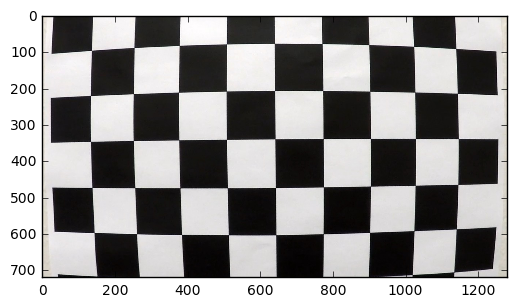

In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

%matplotlib inline  

file = os.getcwd() # get file location

img = mpimg.imread(file + '\camera_cal\calibration1.jpg') # read calibration image

print('Distored Camera Image')
plt.imshow(img)


Next I prepared an empty list where I put the "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I assume the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. "image points" or the imgpoints list will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

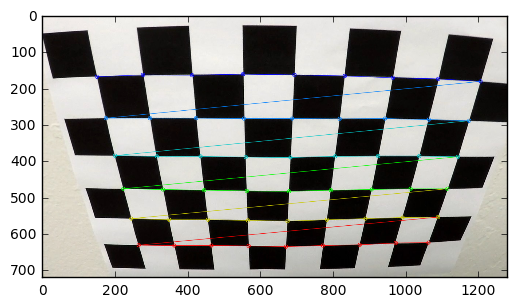

In [2]:
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D image points in image space

nx = 9 # there are 9 corners along x-axis in calibration images
ny = 6 # there are 6 corners along the y-axis in calibration images

objp= np.zeros((nx * ny, 3), np.float32) # create corresponding real world array
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # number grid to create grid of chessboard in real world

img2 = mpimg.imread(file + '\camera_cal\calibration2.jpg') # get second camera image to see how we find corners

gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) # convert camera image to grayscale 
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) # find the corners of the chessboard image

img2 = cv2.drawChessboardCorners(img2, (nx, ny), corners, ret) # draw detected corners on original image
plt.imshow(img2)

Now I will uset the glob api to go through all the calibration images. I will use the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function.

In [3]:
images = glob.glob(file + '\camera_cal\calibration*.jpg') # use glob api to iterate through 20 images for calibration

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

# get camera matrix, mtx, and distortion coefficients, dist, to undistort camera images
retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[:: -1], None, None) 
if retval:
    print('Yes')

Yes


I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

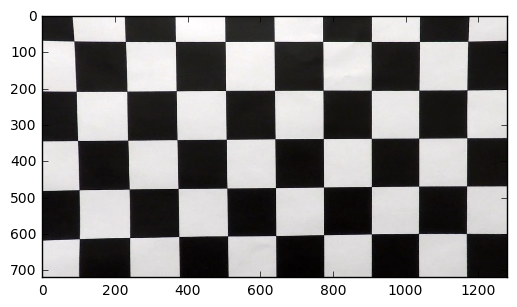

In [4]:
# undistort camera image and show

img = mpimg.imread(file + '\camera_cal\calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

Here's a comparison of Distored Image and Undistorted:

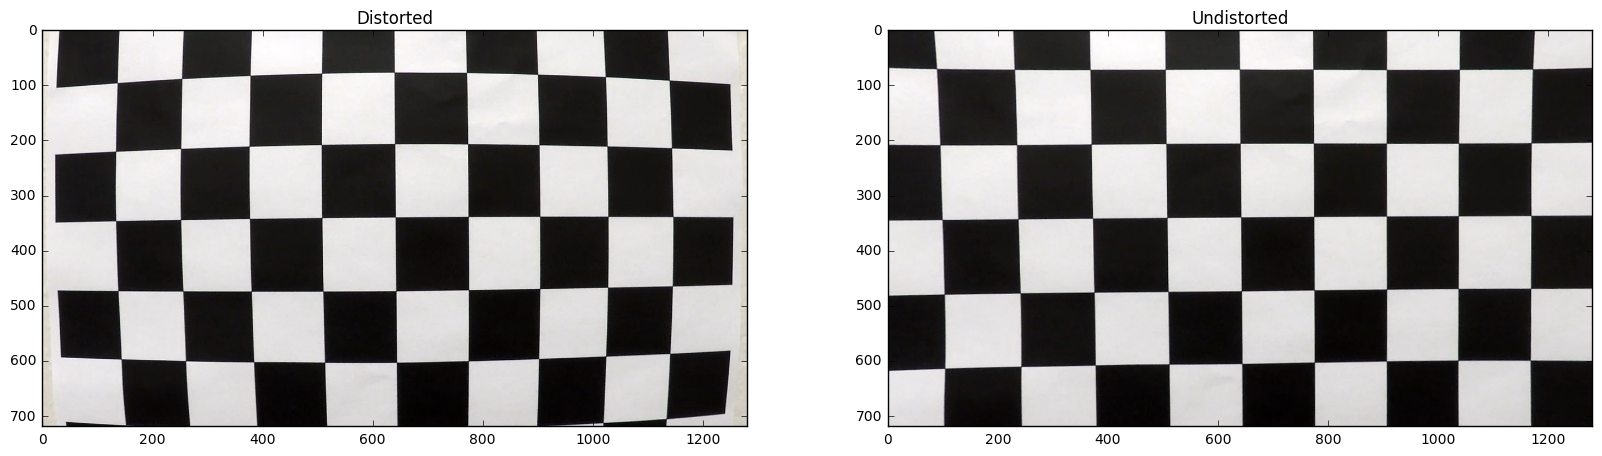

In [5]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Distorted')
ax1.imshow(img)

ax2.set_title('Undistorted')
ax2.imshow(dst)

Here is an example of an original undistored image on the left and our (correction) on the right. 

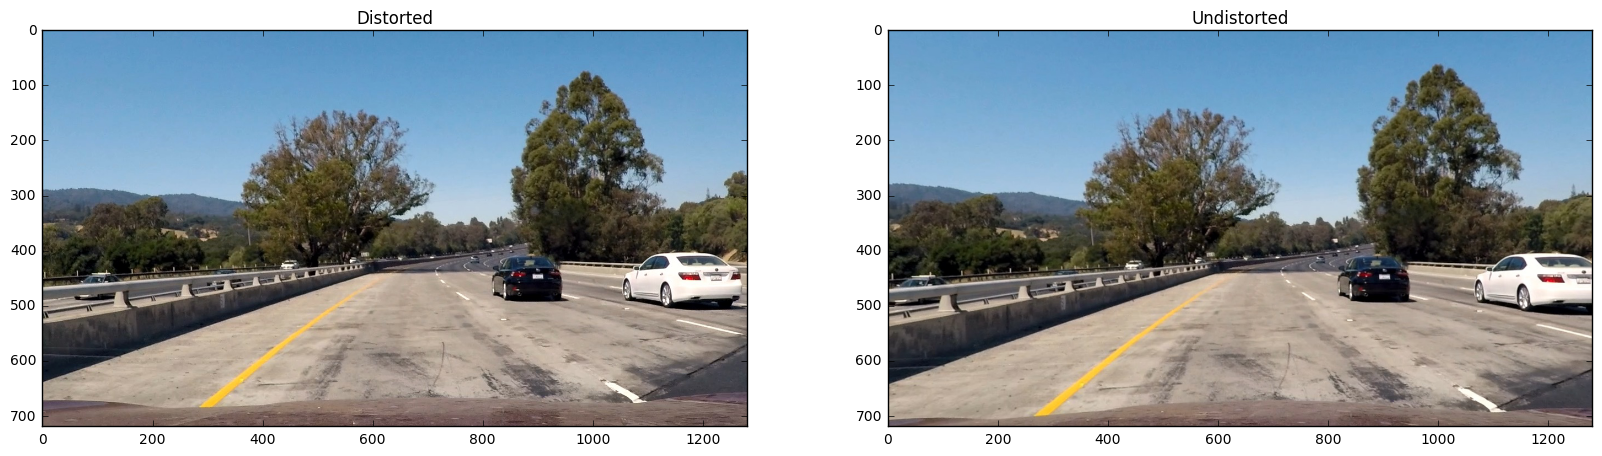

In [6]:
# undistort image of real world object 

img = mpimg.imread(file + '\\test_images\\test1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Distorted')
ax1.imshow(img)

ax2.set_title('Undistorted')
ax2.imshow(dst)

In the cell below I wrote functions that I used to create a thresholded binary image. I wrote a sobel_thresh, mag_thresh, dir_thresh, color_thresh and finally a combine_thresh functions. I tested each of these functions to see which seemed to work the best, changing the parameters of each to spot which ones worked the best with what parameters. I settled on a combined functions that used sobel_thresh function on the x-gradient and a color_thresh function that isolated the saturation channel. I then used a sobel_kernal of size 11 on both and threshold value of (40, 255) on the sobel_thresh function and a threshold value of (100, 255) on the color_thresh function. 

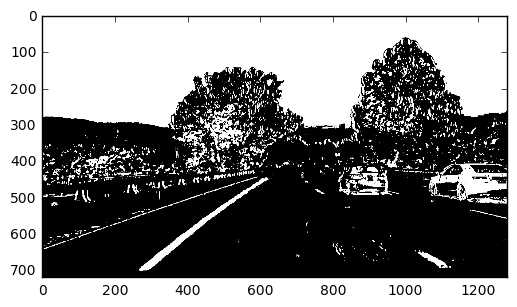

In [7]:
def sobel_thresh(img, orient='x', sobel_kernal=3, thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert color image to gray scale
    
    # cv2.sobel calculates change in color across image - the gradient
    # in the x or y direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernal)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernal)
    # get absolute value of gradient
    abs_sobel = np.absolute(sobel)
    # scale gradient array
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # make copy of image array but make all black - by making all values in array zero
    sbinary = np.zeros_like(scaled_sobel)
    # if gradient at pixel is in our threshold range make pixel one instead of zero
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

def mag_thresh(img, sobel_kernal=3, mthresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert color image to gray scale
    
    # calculate gradient along x and then y gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernal)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernal)
    
    # get magnitude of the x and y gradients 
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_binary = np.zeros_like(mag_sobel)
    # if gradient at pixel is in our threshold range make pixel one instead of zero
    mag_binary[(mag_sobel >= mthresh[0]) & (mag_sobel <= mthresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernal=3, dthresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernal)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernal)
    
    # get absolute value of x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # get direction of gradient, by calculating their arctangent 
    dir_binary = np.arctan2(abs_sobely, abs_sobelx)
    dbinary = np.zeros_like(dir_binary)
    # if gradient at pixel is in our threshold range make pixel one instead of zero
    dbinary[(dir_binary <= dthresh[0]) & (dir_binary >= -dthresh[1])] = 1
    return dbinary

def color_thresh(img, sobel_kernal=3, cthresh=(180, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # convert RGB image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    
    # separate channnels into their own arrays
    H = hls[:, :, 0]
    L = hls[:, :, 1]
    S = hls[:, :, 2]
    # create black copy of one channel array
    binary = np.zeros_like(S)
    
    # Choose saturation channel: through observation saturation channels offers best results
    # if pixel value is in our threshold range make pixel one instead of zero
    binary[(S >= cthresh[0]) & (S <= cthresh[1])] = 1
    return binary

def combine_thresh(img, sobel_kernal=3, thresh=(0,255), mthres=(0, 255), dthresh=(0, np.pi/2), cthresh=(180, 255)):
    
    # combine the color thresh function on saturation channel 
    # and the sobel_thresh function , x-direction
    # through experimenting choose thresh ranges
    sobel = sobel_thresh(img, sobel_kernal=sobel_kernal, thresh=thresh)
    color = color_thresh(img, sobel_kernal=sobel_kernal, cthresh=cthresh)
    combined_binary = np.zeros_like(sobel)
    
    # now if either function returns image where pixel value is one, make that pixel value one
    # the remaining pixel values will be zero.
    combined_binary[(sobel == 1) | (color == 1)] = 1
    return combined_binary

# tdst = sobel_thresh(dst, orient='x', sobel_kernal=11, thresh=(40, 255)) - returned best test results

# tdst = mag_thresh(dst, sobel_kernal=5, mthresh=(20, 255)) - returned best test results

# tdst = dir_thresh(dst, sobel_kernal=3, dthresh=(0, np.pi/2)) - returned best test results

# tdst = color_thresh(dst, sobel_kernal=11, cthresh=(100, 255)) - returned best test results

# overall created combine_thresh function by comgining 2 functions returning best results

tdst = combine_thresh(dst, sobel_kernal=11, thresh=(40, 255), cthresh=(100, 255))

plt.imshow(tdst, cmap='gray')
                              


    


Shift Perspective

I performed a perspective transfom by writing two functions. A warp_matrix function that calculates a transformation matrix and inverse transformation matrix and a warp function that takes the transformation matrix and applies it to images to warp their perspective to a birds eye view. The warp_martix function takes an image and uses source (src) points on the image to map them to destination (dst) points I provide. I use the cv2.getPerspectiveTransform to calculate this matrix. Also, I used the src and dst points provided in the write_template but then just adjusted the pixels on the src pts to make sure the image truly created a warped perspective with parallel lines, I used an image of a straightaway to test this. Then I used the warp function which uses the cv2.warpPerspective function with the transformation matrix provided by warp_matrix to warp an image.

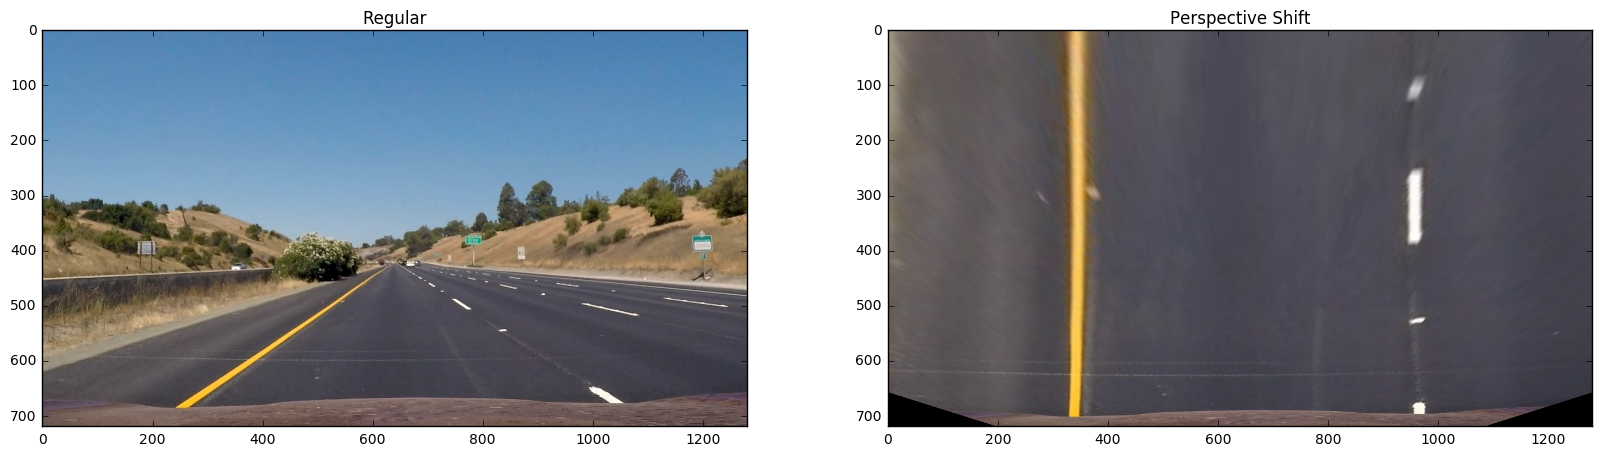

In [8]:
def warp_matrix(img, img_size=(1280, 720)):
    
    # calculate matrix, M,  to warp image to birds eye view
    # calculate inverse matrix, InvM, to return birds eye view image back to normal perspective
  
    # source points on image, adjust through experimentation
    src = np.float32(
    [[(img_size[0] / 2) - 75, img_size[1] / 2 + 108],
    [((img_size[0] / 6) - 35), img_size[1]],
    [(img_size[0] * 5 / 6) + 35, img_size[1]],
    [(img_size[0] / 2 + 75), img_size[1] / 2 + 108]])
    
    # destination points for birds eye perspective transform
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    # use cv2 functions to calculate the matrices
    M = cv2.getPerspectiveTransform(src, dst)
    InvM = cv2.getPerspectiveTransform(dst, src)
    
    return M, InvM

def warp(img, M, dsize=(1280, 720)):
    
    # warp image to birds eye view
    warped = cv2.warpPerspective(img, M, dsize=dsize, flags=cv2.INTER_LINEAR)
    return warped

# get image
straight_image = mpimg.imread(file + '\\test_images\\straight_lines1.jpg')
# get matrix and InverseMatrix to warp image
M, InvM = warp_matrix(straight_image, img_size=(1280, 720)) 
# warp image to birds eye view
warped_image = warp(straight_image, M)

# show image and birds eye perspective of image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Regular')
ax1.imshow(straight_image)

ax2.set_title('Perspective Shift')
ax2.imshow(warped_image)

Now we do a test to find the likely x-positions of the lane lines. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


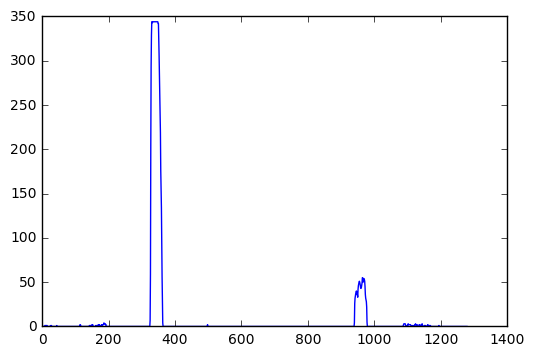

In [9]:
# use combine thresh function to get pixel positions of likely lines
lane_line = combine_thresh(warped_image, sobel_kernal=11, thresh=(40, 255), cthresh=(100, 255))

# plot a graph that shows the x pixel position and the number of pixels where there's a likely line
# on the lower half of the image - where the road is
histogram = np.sum(lane_line[lane_line.shape[0]/2:,:], axis=0)
plt.plot(histogram)

Fit a polynomials to the lane-lines:

Remember, I obtained an image (by using our warp function) of a birds eye persepective of the road. I then used our combine_thresh function to convert this image to a binary image (an image of just 0 and 1 values) with the 1 values being what I  believe to be the lane lines, 0 for everything else. Now I will use the poly_fit_img function to get a histogram of the bottom half of our image to find the most likely x-values for our 2 lane lines. From there I will break our image to a left half - for the left lane and a right half - for the right lane. Then I will create boxes around the likely lane pixel values, using the boxes to limit the x-value at each y value, and then calculating the mean of these x-values for each y value. I will then use the numpy.polyfit function to get a 2nd order polynomial from these pixel values for the left and right lane. I will then use the poly_write_img function to write these polynomials on the binary image. 

2665.39609268 m 3307.56736691 m


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


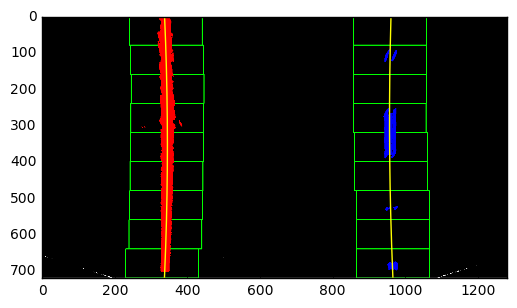

In [10]:
# note these functions are for testing and are not the final method used in class we will create 
# to calculate polynomial and write on image, but they do show how I calculated the polynomial
# without the smoothing factors, and some other minor additions.

def poly_write_img(left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    
    # generate y-values for writing polynomials
    ploty = np.linspace(0, 719, num= 720)
    y_eval = np.max(ploty)
    
    # generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # make likely left lane pixels red, and right lane pixels blue 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    
    # plot yellow lines - a poly that is the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return

def poly_fit_img(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # plt.imshow(out_img)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, 719, num= 720)
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    poly_write_img(left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    
    return left_fit, right_fit
    
binary_warped = lane_line
left_fit, right_fit = poly_fit_img(binary_warped)


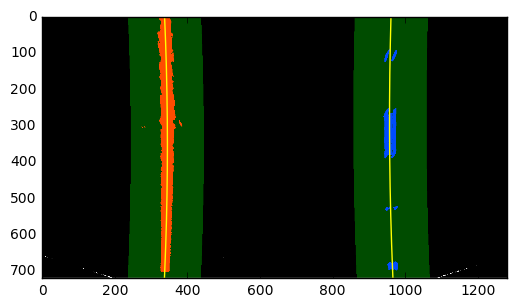

In [11]:
# not the function below shows how I adjusted the function for when we know the range of likely x pixel 
# positions to start looking for lines with some addtional visual adjustments.

def plot_img_adv(binary_warped, left_fit, right_fit):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return

plot_img_adv(binary_warped, left_fit, right_fit)


Finally I created a class function Lanes() which stores whether I need to find the Lanes. It also stores a list of the calculated polynomial coefficients - which represent the polynomials for the left and right lanes in our images. I will use this to smooth the lane detections so eggresiously errant values aren't displayed. The poly_fit method in the lanes class takes an image from a video and undistorts the camera distortion, converts the image to a binary image using the combined_thresh function  and then converts this binary image to a birds eye view perspective. The method also uses the same steps as the functions described in the previous cells to calculate the polynomial but it smooths the polynomials by using an average of the previous polynomial coefficients to calculate the new polynomial coefficient and then writing the lane information to the original image. The method also calculates the radius of curvature by using the radius of curvature formula (2Ay + B) / 2A from our calculated right and left lane polymials and getting the average of them. Additonally, I calculated the car's offset from the middle of the lane by calculating how far the center of the road is from the center of our image - the last two calculations are performed at the end of the poly_fit method.   

In [18]:
# Define a class to receive the characteristics of each line detection
class Lanes():
    
    def __init__(self, mtx, dist, M, InvM):
        
        # was the line detected 
        self.detected = False  
        # camera distortion matrix
        self.camera_mtx = mtx
        # camera distortion coefficients
        self.camera_dist = dist
        # warp perspective to birds eye view
        self.birds_eye = M
        # warp perspective back from birds eye view
        self.birds_eye_inv = InvM
        # list of left lane polynomial coefficients
        self.left_fit = []
        # list of right lane polynomial coefficients 
        self.right_fit = []

    def poly_fit(self, img):
        
        # method will take raw image and draw lane
        # calculate radius of road curvature
        # calculate offset from center of road 
        # update class attributes for smoothing. 
        
        # undistort normal camera distortion of image
        dst = cv2.undistort(img, self.camera_mtx, self.camera_dist, None, self.camera_mtx)

        # get binary thresholded image
        tdst = combine_thresh(dst, sobel_kernal=11, thresh=(40, 255), cthresh=(100, 255))
        
        # shift perspective - birdseye view of binary image
        binary_warped = warp(tdst, self.birds_eye)
    
        if not self.detected:
            
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
            
            # Find the peak of the left and right halves of the histogram
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            
            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            # add polyfit to class attributes 
            self.left_fit.append(left_fit)
            self.right_fit.append(right_fit)
            
            self.detected = True
        else:
            
            # Assume we now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            left_fit = np.mean(self.left_fit[-10:], axis=0)
            right_fit = np.mean(self.right_fit[-10:], axis=0)
            margin = 100
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            # add polyfit to class attributes 
            self.left_fit.append(left_fit)
            self.right_fit.append(right_fit)
            
        # average out last three polys for smoothing
        left_fit = np.mean(self.left_fit[-3:], axis=0)
        right_fit = np.mean(self.right_fit[-3:], axis=0)
            
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_lane = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_lane = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        road_pts = np.hstack((left_lane, right_lane))
        
        # Draw the lane onto the warped blank image
        result = cv2.fillPoly(window_img, np.int_([road_pts]), (0,100, 0))
        result = warp(result, self.birds_eye_inv)
        result = cv2.addWeighted(img, 1, result, 0.3, 0)
        
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        ploty = np.linspace(0, 719, num= 720)
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/640 # meters per pixel in x dimension 
        
        # Fit new polynomials to x, y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # get radius of curvature of road as average of left and right curvature
        average_rad = (left_curverad + right_curverad) / 2
        curve = str(round(average_rad, 0))
        
        # calculate the car's offset from center of road
        left_intercept = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_intercept = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        camera_center = (left_intercept + right_intercept) / 2
        center_diff = (camera_center - (1280/2)) * xm_per_pix
        side_pos = 'Left'
        if center_diff <= 0:
            side_pos = 'Right'
        center = str(abs(round(center_diff, 3)))
        
        # print offset from cente of road and the radius of curvature on the image
        cv2.putText(result, 'The Car is ' + center + 'm' + ' to the ' + side_pos + ' of the center of the road',
                    (50, 50 ), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
        cv2.putText(result, 'The Radius of Curvature is ' + curve + 'm',(50, 100 ), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
        
        return result


In [19]:
# create an instance of our Lanes() class - drive - to process our raw images 
drive = Lanes(mtx, dist, M, InvM)

def process_image(image):   
    return drive.poly_fit(image)
     
        

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# get raw video
clip = VideoFileClip(file + '\project_video.mp4')
# process raw image to create driving lane, radius of curvature and offset from center
outclip = clip.fl_image(process_image)
# write the output video to file
%time outclip.write_videofile('output_video.mp4', audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:53<00:00, 11.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 1min 53s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_video.mp4'))

The biggest issue I faced was probably getting the birds eys perspective shift correct. I was never really sure whether the shift I created was good enough. Also, I had to overcome my initial disinclination to manually pick pixels and adjust by just looking at whether it looked straight. Ultimately, I decided it did look straight enough and that manually manipulating values is part of the experimentation process - it was more of a mental block than anything else. My pipeline will definitely fail if the car goes outside either lane line. That's something that could be mitigated by periodically doing manual searches for the lines and then doing the histogram lane line detection during these checks. It was not necessary for this video segment. Also, let's say something happened and the car became perpendicular to the lanes. Additonal code would have to be written to look for horizontal and diagonal lines, in those cases - using a histogram lane search for those perspectives. Cheers!